
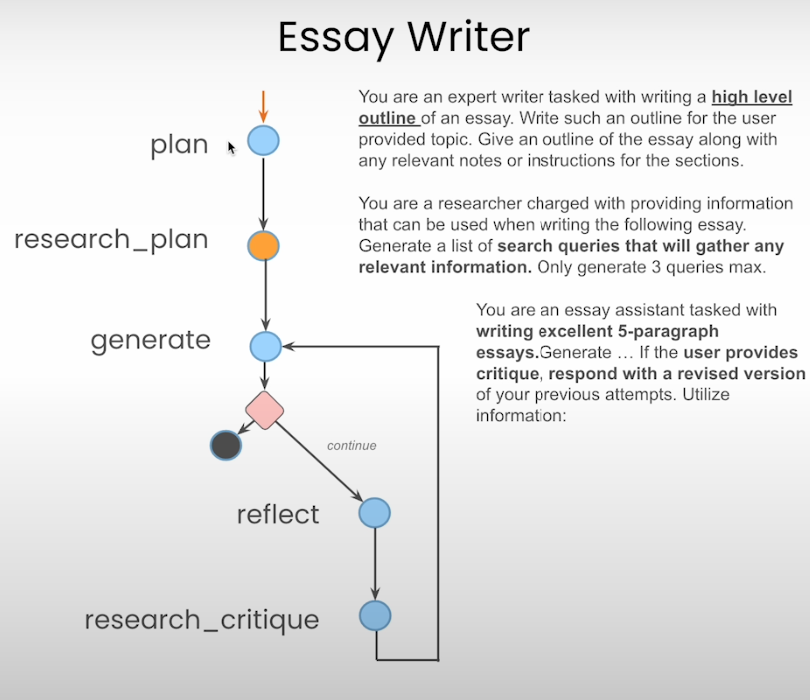

In [51]:
from dotenv import load_dotenv, find_dotenv
_=load_dotenv(find_dotenv())

In [52]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated, List
import operator
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
import warnings
warnings.filterwarnings('ignore')
memory = MemorySaver()


In [53]:
class AgentState(TypedDict):
    task: str # Human Input
    plan: str # plan the planning agent will generate
    draft: str # draft of the essay (essay writer)
    critique: str # Critic agent will populate this
    content: List[str] # List of documents trivili has researched and come back with
    revision_number: int # Number of revisions we have made
    max_revisions: int # Max revisions we want to make. 
    #the last two as used as criteria to decide to stop or not.
    
    

In [54]:
from langchain_openai import ChatOpenAI
model = ChatOpenAI(model='gpt-3.5-turbo', temperature=0)

In [55]:
PLAN_PROMPT = ''' You are an expert writer tasked with writing a high level outline of the essay
                  Write such an outline for the user to provided topic. Give an outline of the essay along with any relevant notes
                  or instructions for the sections'''

In [56]:
WRITER_PROMPT = ''' You are an essay assistant tasked with writing excellent 5-paragraph essays.
Generate the best essay possible for the user's request and the initial outline.
If the user provides critique, respond with a revised version of your previous attempts.
Utilize all the information below as needed.

---
{content}'''

In [ ]:
REFLECTION_PROMPT = ''' You are a teacher grading an essay submission. Generate critique and recommendations for the user submission.
                        Provide detailed recommendations, including request for length, depth, style etc.'''

In [58]:
RESEARCH_PLAN_PROMPT = ''' You are a research charged with information that can be used when writing the following essay.
                           Generate a list of search queries that will gather any relevant information. 
                           Only generate 3 queries max'''

In [59]:
RESEARCH_CRITIQUE_PROMPT = ''' You are a researcher charged with providing information 
that can be used when making an requested revision (as outlined below).
Generate a list of search queries that will gather any relevant relevant information. 
Only Generate 3 queries max.
                            
'''

In [60]:
from langchain_core.pydantic_v1 import BaseModel

class Queries(BaseModel):
    queries: List[str]

In [61]:
from tavily import TavilyClient
import os
tavily = TavilyClient(api_key=os.environ["TAVILY_API_KEY"])

In [62]:
def plan_mode (state: AgentState):
    # print ("entering plan node")
    messages =[
        SystemMessage(content=PLAN_PROMPT),
        HumanMessage(content=state['task'])
    ]
    response = model.invoke(messages)
    return {"plan": response.content}

In [63]:
def research_plan_node(state:AgentState):
    # print ("entering research plan node")
    queries= model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_PLAN_PROMPT),
        HumanMessage(content = state['task'])
    ])
    print ("Areas to do more research: ")
    # for q in queries.queries:        
    # print (f"{queries}")
    content = state.get('content', [])
    # print (f'content constructed {content}')
    query_count=1
    for q in queries.queries:        
        print (f"Topic {query_count}: {q}")
        response = tavily.search(query=q, max_results=2)
        query_count +=1
        for r in response['results']:
            content.append(r['content'])
    # print (f'content constructed {content}')
    return {"content": content}

In [64]:
def generation_node(state:AgentState):
    # print ("entering generation node")
    content = "\n\n".join(state["content"] or [])
    user_message = HumanMessage(
        content = f'{state['task']} \n\n Here is my plan: {state['plan']}'
    )
    messages = [SystemMessage(content= WRITER_PROMPT.format(content=content)),
                user_message]
    response = model.invoke(messages)
    print (f"Draft Version {state['revision_number']+1}/{state['max_revisions']+1}")
    print (response.content)
    return {
        "draft": response.content,
        "revision_number": state.get("revision_number", 1)+1
    }
    
    

In [65]:
def reflection_node(state:AgentState):
    # print ("Entering reflection node")
    messages = [
        SystemMessage(content=REFLECTION_PROMPT),
        HumanMessage(content=state["draft"])
    ]
    response = model.invoke(messages)
    print ("Areas to improve:")
    print (response.content)
    return {
        "critique": response.content
    }

In [66]:
def research_critique_node(state:AgentState):
    # print ("entering reearch critique node")
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_CRITIQUE_PROMPT),
        HumanMessage(content=state['critique'])
    ])
    content = state['content'] or []
    print ("Based on the critique, areas to do more research on...")
    query_count = 1
    for q in queries.queries:
        print (f'Topic {query_count}: {q}')
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
    return {"content": content}

In [67]:
def should_continue(state:AgentState):
    # print ("entering should continue node")
    if state['revision_number'] > state['max_revisions']:
        print ("completing the draft versions")
        return END
    # print ("continuing to reflect")
    return "reflect"

In [68]:
builder = StateGraph(AgentState)

In [69]:
builder.add_node("planner", plan_mode)
builder.add_node("generate", generation_node)
builder.add_node("reflect", reflection_node)
builder.add_node("research_plan", research_plan_node)
builder.add_node("research_critique", research_critique_node)


In [70]:
builder.set_entry_point("planner")

In [71]:
builder.add_conditional_edges(
    "generate",
    should_continue,
    {END: END, "reflect": "reflect"}
)

In [72]:
builder.add_edge("planner", "research_plan")
builder.add_edge("research_plan", "generate")
builder.add_edge("reflect", "research_critique")
builder.add_edge("research_critique", "generate")

In [73]:
graph = builder.compile(checkpointer=memory)

In [74]:
thread = {"configurable":{"thread_id": "1"}}
task_params = {
    'task': "Why does a 5th grader always procrastinates on this science fair project and always wants to play roblox",
    'max_revisions':2,
    'revision_number':0
}

print (f"Task at hand: {task_params['task']}")
draft_version = 0
for s in graph.stream(task_params, thread):
    if "planner" in s:
        print (f"Plan: {s["planner"]['plan']}")
    # if ("generate" in s) :
    #     if draft_version ==0:
    #         print (f"1st Version (Draft) 1/{task_params['max_revisions']+1}")
    #     else:
    #         draft_version=1
    #         print ("Draft Generated based on topic research results...")
    #         print (f"Revision: {s['generate']['revision_number']}/{ task_params['max_revisions']+1}")
    #     print (f"Here is the first draft: {s['generate']['draft']}")

            

Task at hand: Why does a 5th grader always procrastinates on this science fair project and always wants to play roblox
Plan: I. Introduction
    A. Introduce the topic of procrastination in 5th graders
    B. Mention the allure of playing Roblox over working on a science fair project

II. Understanding Procrastination in 5th Graders
    A. Define procrastination and its impact on productivity
    B. Discuss common reasons why 5th graders procrastinate
        1. Fear of failure
        2. Lack of interest in the project
        3. Overwhelmed by the task
        4. Desire for immediate gratification (playing Roblox)

III. Impact of Procrastination on Academic Performance
    A. Explain how procrastination can affect the quality of work
    B. Discuss potential consequences of procrastination on grades and learning

IV. Strategies to Overcome Procrastination
    A. Provide tips for 5th graders to manage procrastination
        1. Breaking down tasks into smaller, manageable steps
      

In [75]:
# for s in graph.stream(task_params, thread):
#     print (s)